In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import shapefile as shp
import datetime 
import warnings
xr.set_options(keep_attrs=True)
do_parallel       = True
parallel_nprc     = 48   # number of dask workers
parallel_nprc_bin = 10   # number of processor used to parallize the binning loop
parallel_tmem     = 200  # max. available RAM

/albedo/home/pscholz/tripyview


## INFO:
To compute the MOC especially on large unstructures grids #vertices>1M you need to run this notebook in parallel on several workers. Therefor allocate a full compute node of a HPC with as much memory as you can get!

In [2]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

 --> memory_limit: 4.167 GB


In [7]:
#_____________________________________________________________________________________
# set mesh path
mesh_path  = '/albedo/work/user/pscholz/data_cmpi6/bold/'
# set path to save figures and netcdf files
save_path  = None #'~/figures/test_MOC_f14cmip6/' # None

# set datapath
input_paths= list()
input_paths.append('/albedo/work/user/pscholz/data_cmpi6/')

#_____________________________________________________________________________________
# set run infos
which_model= 'AWI-CM-1-1-HR'
which_run  = 'control-1950'
vname      = 'amoc'  # gmoc, amoc, ipmoc, imoc, pmoc
year       = [1951, 2050]
dyr        = 10

#_____________________________________________________________________________________
cstr       = 'blue2red'
cnum, cref, crange, cmin, cmax, cfac, climit = 20, 0, None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncol              = 2      # number of pannel columns in figure
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = True  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh, mesh_opt = False, dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
# do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']
do_bolus          = True
do_netcdf         = True
do_info           = True

## > Load mesh:

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True, do_f14cmip6=True)

#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)

#______________________________________________________________________________________________________        
if save_path is not None:
    if not os.path.isdir(save_path): os.makedirs(save_path)

#______________________________________________________________________________________________________                
# chunks ={'time'   :100, 
#          'nod2'   :np.ceil(mesh.n2dn/n_workers), 
#          'elem'   :np.ceil(mesh.n2de/n_workers), 
#          'ncells' :np.ceil(mesh.n2dn/n_workers), 
#          'ntriags':np.ceil(mesh.n2de/n_workers)}  
chunks ={'time'   :'auto', 
         'nod2'   :'auto', 
         'elem'   :'auto', 
         'ncells' :'auto', 
         'ntriags':'auto', }   

 > found *.pckl file: /albedo/work/user/pscholz/data_cmpi6/bold
 > load  *.pckl file: tripyview_fesom2_bold_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/data_cmpi6/bold
 > id              = bold
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 1306775
 > #elem           = 2583730
 > #lvls           = 46
___________________________________________


##  > Compute: MOC vs. time
- compute annual mean MOC from monthly mean FESOM1.4 AWI-CM-1-1-HR CMIP6 vertical velocities (var:wo)

In [23]:
#______________________________________________________________________________________________________
ts     = clock.time()
zmoc_t = xr.Dataset()
for ii, datapath in enumerate(input_paths): 
    print(datapath)

    #__________________________________________________________________________________________________
    # loop over year to open 10-year bundled files 
    t1s = clock.time()
    for yr in range(year[0], year[1]+1, dyr):
        
        #______________________________________________________________________________________________
        # load cmip6 filename
        fname       = f'wo_Omon_{which_model}_{which_run}_r1i1p1f2_gn_{yr}01-{yr+dyr-1}12.nc'
        filepath    = os.path.join(datapath, fname)
        print(' --> open file:', fname)
        
        # load data via xarray
        data = xr.open_mfdataset(filepath, parallel=True, chunks=chunks, autoclose=False)
            
        #______________________________________________________________________________________________
        # convert format from fesom14cmip6 --> fesom2
        if do_info: print('     --> convert f14cmip6 > fesom2')
        data = data.drop_vars(['lon_bnds','lat_bnds', 'time_bnds'])
        data = data.rename_dims({'ncells':'nod2', 'depth':'nz'})
        data = data.rename({'wo':'w', 'depth':'nz'})
        data = data.transpose('time', 'nod2', 'nz')
       
        #______________________________________________________________________________________________
        # compute time mean 
        if do_info: print('     --> compute annual time mean')
        data = data.groupby('time.year').mean('time')
        
        # recreate time axes based on year
        data = data.rename_dims({'year':'time'})
        if yr in data.year.values:
            data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop_vars('year')
        else:
            raise ValueError('--> the years you want load can not be found in the time axis of your file. Something is not OK with the data! Check on them!!!')
            
        if do_info: print('     --> xr.compute() ... load everything into memory. This can take a bit!')
        data = data.compute()
        data['w'].attrs['descript'] = f'{which_run}'
        
        #______________________________________________________________________________________________
        # compute zmoc    
        if do_info: print('     --> compute: ', vname)
        zmoc = tpv.calc_zmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=do_info, do_checkbasin=False, do_onelem=False, diagpath=False, 
                             do_load=True, do_parallel=do_parallel, n_workers=parallel_nprc_bin)
        del(data)
        
        #______________________________________________________________________________________________
        # accumulate to zmoc over time
        zmoc_t = xr.merge([zmoc_t, zmoc], combine_attrs='drop_conflicts') #no_conflicts
        del(zmoc)
        
        #______________________________________________________________________________________________
        t1e = clock.time()
        print('     --> elapsed time/file:', t1e-t1s, ' sec')
        t1s = t1e
        print('\n')
    
    #__________________________________________________________________________________________________
    # save to netcdf
    if do_netcdf and save_path is not None:
        auxtime   = zmoc_t['time.year'].values
        sfname    = f'{vname}_vs_t_{which_model}_{which_run}_y{auxtime[0]}-{auxtime[-1]}.nc'
        # sfilepath = os.path.join(datapath, sfname)
        sfilepath = os.path.join(save_path, sfname)
        print(' --> save zmoc_t to file:', sfname)
        zmoc_t.to_netcdf(path=sfilepath, mode='w')
    
print(' --> tot. elapsed time:', clock.time()-ts, ' sec')

/albedo/work/user/pscholz/data_cmpi6/
 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_195101-196012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean
     --> xr.compute() ... load everything into memory. This can take a bit!


/tmp/ipykernel_78096/1031463213.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_78096/1031463213.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop_vars('year')


     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____

 ___parallel loop over longitudinal bins____
 --> do cumsum over latitudes
 --> total time:3.152 s
     --> elapsed time/file: 32.13939905166626  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_196101-197012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean
     --> xr.compute() ... load everything into memory. This can take a bit!


/tmp/ipykernel_78096/1031463213.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_78096/1031463213.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop_vars('year')


     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____

 ___parallel loop over longitudinal bins____
 --> do cumsum over latitudes
 --> total time:2.363 s
     --> elapsed time/file: 32.85008120536804  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_197101-198012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean


/tmp/ipykernel_78096/1031463213.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_78096/1031463213.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop_vars('year')


     --> xr.compute() ... load everything into memory. This can take a bit!
     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____

 ___parallel loop over longitudinal bins____
 --> do cumsum over latitudes
 --> total time:2.405 s
     --> elapsed time/file: 33.870280742645264  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_198101-199012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean
     --> xr.compute() ... load everything into memory. This can take a bit!


/tmp/ipykernel_78096/1031463213.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_78096/1031463213.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop_vars('year')


     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____

 ___parallel loop over longitudinal bins____
 --> do cumsum over latitudes
 --> total time:2.700 s
     --> elapsed time/file: 32.63282513618469  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_199101-200012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean
     --> xr.compute() ... load everything into memory. This can take a bit!


/tmp/ipykernel_78096/1031463213.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_78096/1031463213.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop_vars('year')


     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____

 ___parallel loop over longitudinal bins____
 --> do cumsum over latitudes
 --> total time:2.714 s
     --> elapsed time/file: 33.335665225982666  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_200101-201012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean


/tmp/ipykernel_78096/1031463213.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_78096/1031463213.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop_vars('year')


     --> xr.compute() ... load everything into memory. This can take a bit!
     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____

 ___parallel loop over longitudinal bins____
 --> do cumsum over latitudes
 --> total time:2.375 s
     --> elapsed time/file: 32.950008392333984  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_201101-202012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean
     --> xr.compute() ... load everything into memory. This can take a bit!


/tmp/ipykernel_78096/1031463213.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_78096/1031463213.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop_vars('year')


     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____

 ___parallel loop over longitudinal bins____
 --> do cumsum over latitudes
 --> total time:2.349 s
     --> elapsed time/file: 34.5544331073761  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_202101-203012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean


/tmp/ipykernel_78096/1031463213.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_78096/1031463213.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop_vars('year')


     --> xr.compute() ... load everything into memory. This can take a bit!
     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____

 ___parallel loop over longitudinal bins____
 --> do cumsum over latitudes
 --> total time:2.431 s
     --> elapsed time/file: 34.168297290802  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_203101-204012.nc
     --> convert f14cmip6 > fesom2


/tmp/ipykernel_78096/1031463213.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_78096/1031463213.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop_vars('year')


     --> compute annual time mean
     --> xr.compute() ... load everything into memory. This can take a bit!
     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____

 ___parallel loop over longitudinal bins____
 --> do cumsum over latitudes
 --> total time:2.521 s
     --> elapsed time/file: 32.85761308670044  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_204101-205012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean


/tmp/ipykernel_78096/1031463213.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_78096/1031463213.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop_vars('year')


     --> xr.compute() ... load everything into memory. This can take a bit!
     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____

 ___parallel loop over longitudinal bins____
 --> do cumsum over latitudes
 --> total time:2.824 s
     --> elapsed time/file: 32.49549746513367  sec


 --> tot. elapsed time: 331.85490012168884  sec


##  > Plot: mean MOC 

--> histo: cmin, cmax =  -0.2383032739162445 27.31954002380371
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -0.24, 'cmax': 27.32, 'cmap': <matplotlib.colors.ListedColormap object at 0x154efb709d60>, 'clevel': array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
       25., 26., 27., 28.]), 'clab': array([ 0.,  4.,  8., 12., 16., 20., 24., 28.])}


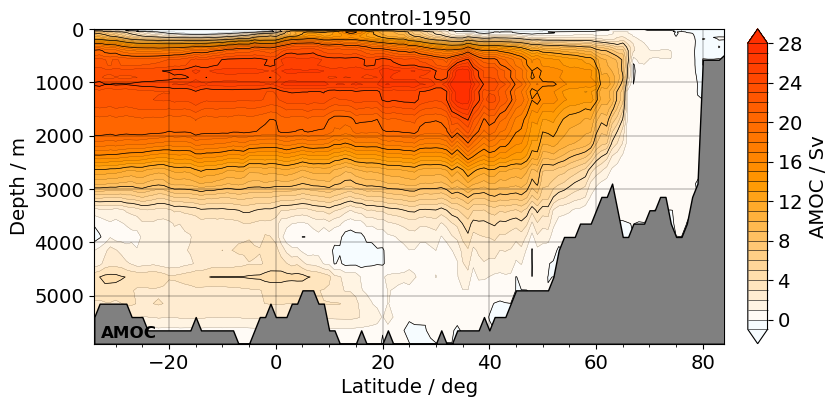

In [24]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
# spath  = save_path
# auxtime= zmoc_t['time.year'].values
# slabel = f'y{auxtime[0]}-{auxtime[-1]}'
# if spath is not None: spath  = os.path.join(spath,'{}_{}_{}_{}.png'.format(vname, which_model, which_run, slabel)) 
# nrow, ncol= 1,1

# #____________________________________________________________________________________________________
# fig, ax, cbar=tpv.plot_zmoc([zmoc_t.mean(dim='time', keep_attrs=True)], which_moc=vname, cinfo=cinfo, figsize=[ncol*figfac[0], nrow*figfac[1]], 
#                             n_rc=[nrow, ncol], pos_gap=[0.01, 0.04], pos_extend=[0.05, 0.05, 0.85, 0.90], 
#                             do_save=spath, save_dpi=which_dpi, do_contour=True)

#__________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
auxtime= zmoc_t['time.year'].values
slabel = f'y{auxtime[0]}-{auxtime[-1]}'
nrow0, ncol0= 1,1

if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, which_model, which_run ,slabel, sfmt)) )
    
#__________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
    
#__________________________________________________________________________________________________    
hfig, hax, hcb = tpv.plot_vslice(mesh, [zmoc_t.mean(dim='time', keep_attrs=True)], nrow=nrow0, ncol=ncol0, cinfo=cinfo0, 
                                    do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                    ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                    cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                    do_save=sfpath, save_dpi=save_dpi )    

## > Compute: MOC time series @ latitude

In [25]:
zdefuc,zdeflc = [500,2000], [1500, 6000] # z-definition for upper/lower cell

#____________________________________________________________________________________________________
# compute time-series
if  vname == 'ipmoc' or vname == 'pmoc':
    zmoc_maxatlat = zmoc_t.where((zmoc_t['depth']>=zdeflc[0]) & (zmoc_t['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_lcell'})
elif vname == 'amoc' or vname == 'aamoc':
    zmoc_ucell  = zmoc_t.where((zmoc_t['depth']>=zdefuc[0]) & (zmoc_t['depth']<=zdefuc[1])).max(dim='nz',skipna=True).rename({'zmoc':'zmoc_ucell'})
    zmoc_lcell  = zmoc_t.where((zmoc_t['depth']>=zdeflc[0]) & (zmoc_t['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_lcell'})
    zmoc_maxatlat = xr.merge([zmoc_ucell, zmoc_lcell], compat='minimal' )
    del(zmoc_ucell, zmoc_lcell)

#_____________________________________________________________________________________________________
# save to netcdf
if (do_netcdf) and (save_path is not None) and (vname in ['amoc', 'aamoc', 'ipmoc', 'pmoc']):
    auxtime   = zmoc_t['time.year'].values
    sfname    = f'{vname}_at_lat_vs_t_{which_model}_{which_run}_y{auxtime[0]}-{auxtime[-1]}.nc'
    sfilepath = os.path.join(save_path, sfname)
    print(' --> save max. zmoc_t @ lat. to file:', sfname)
    zmoc_maxatlat.to_netcdf(path=sfilepath, mode='w')        

## > Plot: MOC time-series @ latitude

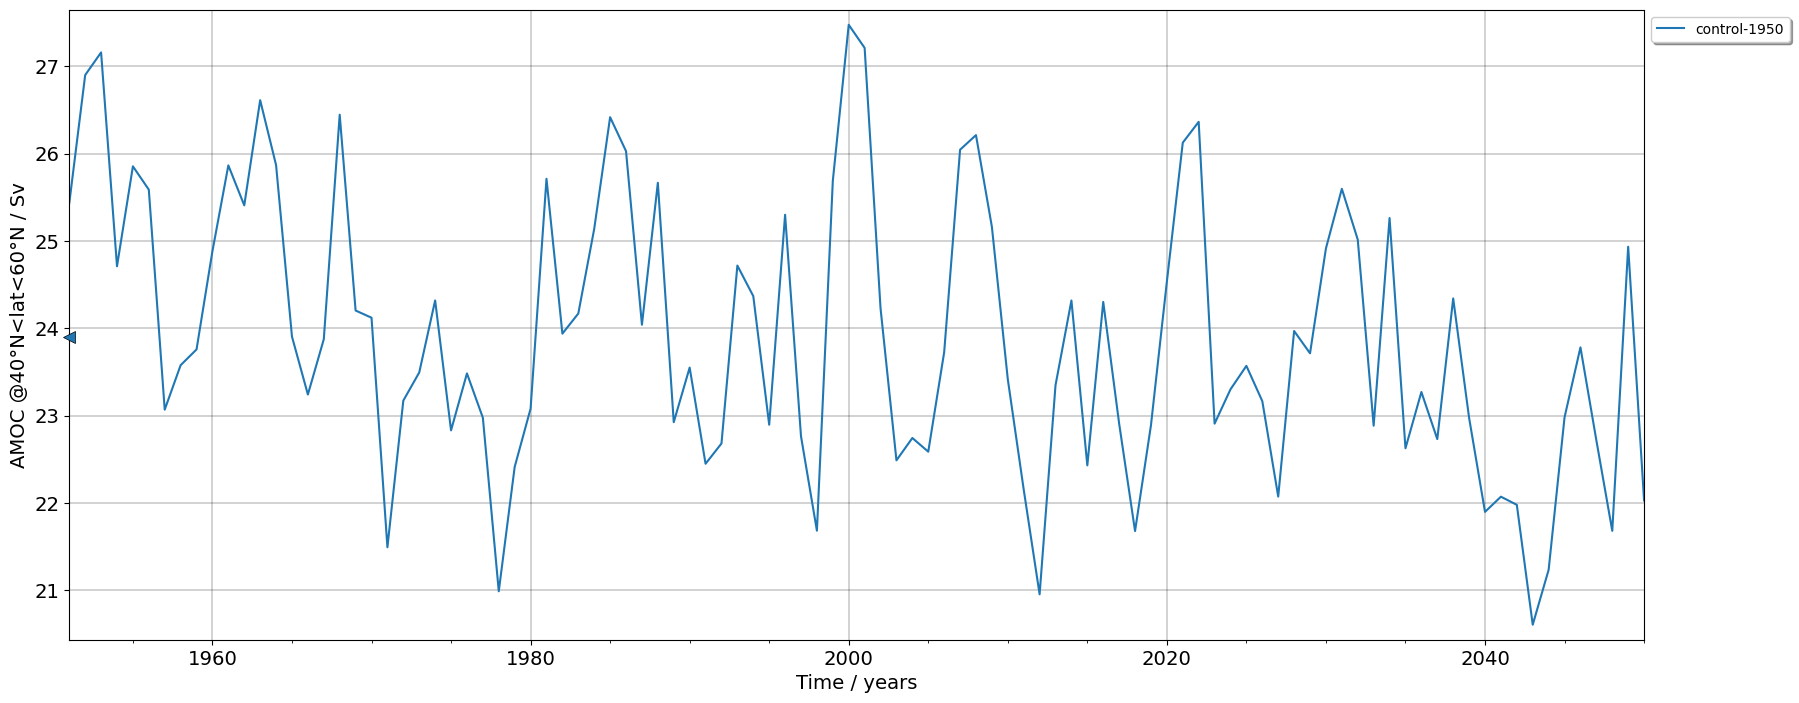

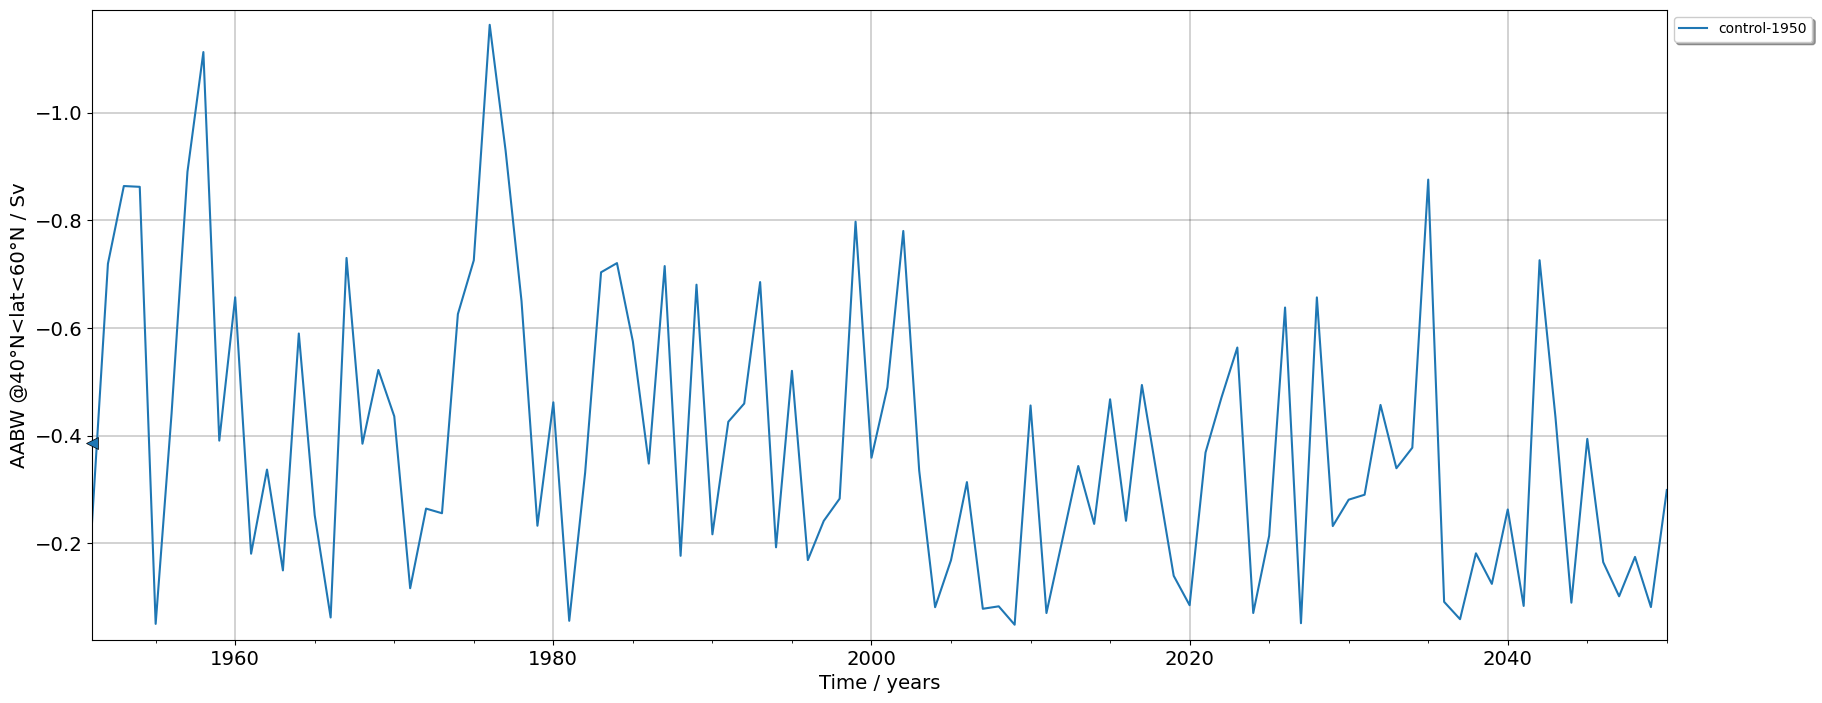

In [26]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
which_lat = ['max'] # 'max' # 'max', 26.0

#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AMOC at lat
for lat in which_lat: 
    lat_list = list()
    for data in [zmoc_maxatlat]:
        for var in data.data_vars:
            #_______________________________________________________________
            if var in ['zmoc_nadw','zmoc_ucell']:
                data_lat = zmoc_maxatlat[var].to_dataset(promote_attrs=True)
                if lat=='max':
                    data_lat = data_lat.isel(lat=(data.lat>40) & (data.lat<60)).max(dim='lat') 
                    str_label= f'@{40}°N<lat<{60}°N'
                elif isinstance(lat, list):    
                    data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).max(dim='lat') 
                    str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                else:     
                    data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                    if lat>=0: str_label= f'@{lat}°N'
                    else     : str_label= f'@{lat}°S'  
                data_lat[var].attrs['add2ylabel'] = str_label
                lat_list.append([data_lat])        
    
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(lat_list[0][0].data_vars)[0]
    auxtime   = zmoc_t['time.year'].values
    slabel = f'y{auxtime[0]}-{auxtime[-1]}'

    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'which_model', which_run ,slabel, sfmt)) )

    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1     , 
                            do_allcycl = False               , 
                            do_concat  = False               , 
                            do_shdw    = False               ,
                            do_mean    = True                ,
                            do_std     = False               ,
                            ax_opt     = dict({'fig_sizefac':4}) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                         )

    
    
#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AABW at lat
for lat in which_lat: 
    lat_list = list()
    for data in [zmoc_maxatlat]:
        for var in data.data_vars:
            #_______________________________________________________________
            if var in ['zmoc_aabw','zmoc_lcell']:
                data_lat = data[var].to_dataset(promote_attrs=True)
                if lat=='max':
                    data_lat = data_lat.isel(lat=(data.lat>40) & (data.lat<60)).min(dim='lat') 
                    str_label= f'@{40}°N<lat<{60}°N'
                elif isinstance(lat, list):    
                    data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).min(dim='lat') 
                    str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                else:     
                    data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                    if lat>=0: str_label= f'@{lat}°N'
                    else     : str_label= f'@{lat}°S'  
                data_lat[var].attrs['add2ylabel'] = str_label
                data_lat[var].attrs['short_name'] = 'AABW'
                data_lat[var].attrs['long_name']  = 'AABW'
                lat_list.append([data_lat])        
        
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(lat_list[0][0].data_vars)[0]
    auxtime   = zmoc_t['time.year'].values
    slabel = f'y{auxtime[0]}-{auxtime[-1]}'

    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'which_model', which_run ,slabel, sfmt)) )

    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1     , 
                            do_allcycl = False               , 
                            do_concat  = False               , 
                            do_shdw    = False               ,
                            do_mean    = True                ,
                            do_std     = False               ,
                            ax_opt     = dict({'fig_sizefac':4}) ,
                            grid_opt   = dict({'do_yinv':True}) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                         )